In [245]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import random
import cmath
import math

# Define our buildDataSet function here!

In [246]:
def buildDataSet(max_amplitude, min_sparsity, max_sparsity, vector_size, data_set_size):
    sparse_data = np.zeros((vector_size, data_set_size), dtype=float)  # Ensure float type
    
    # Iterate over the columns of the sparse_data matrix to define the data samples
    for i in range(data_set_size):
        sparsity = random.randint(min_sparsity, max_sparsity)
        indices = random.sample(range(vector_size), sparsity)
        amps = np.random.uniform(-max_amplitude, max_amplitude, sparsity)  # Use negative and positive values
        sparse_data[indices, i] = amps
    
    # Define the DFT matrix and multiply our sparse_data vectors with it to find dense data
    DFT = sp.linalg.dft(vector_size) / np.sqrt(vector_size)
    dense_data = DFT @ sparse_data
    
    return dense_data, sparse_data




## Build the dataset

In [247]:
max_amplitude = 100
min_sparsity = 3
max_sparsity = 5
vector_size = 100
data_set_size = 10000
dense_data, sparse_data = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,data_set_size)



## Test the dataset

In [171]:
DFT = sp.linalg.dft(vector_size)/np.sqrt(vector_size)
iDFT = DFT.conj().T

# Check if the iDFT of the dense data is in fact sparse
print(iDFT@dense_data)


[[-3.69475549e-14+1.30313504e-13j -4.49710076e-13-5.40593016e-14j
  -1.13830871e-13-1.61130447e-14j ... -6.24351033e-14-1.48058413e-14j
  -3.51432294e-14-3.12667292e-14j -4.71820098e-14+1.21958769e-13j]
 [ 1.28122547e-14+3.48339465e-14j -1.22802549e-14+3.66334648e-13j
  -1.08357767e-13+1.33884935e-14j ... -2.12770112e-14+1.46873065e-14j
   2.62815565e-14+5.84661110e-14j  1.47473552e-13+9.55123081e-14j]
 [ 9.77179428e-14+7.04207629e-14j  1.42108547e-13+9.40666960e-14j
  -1.80824248e-14+8.91904551e-14j ...  4.29666497e+01+8.35425225e-14j
  -4.74375696e-14-9.85055902e-14j  8.04069372e-14-1.56180736e-13j]
 ...
 [ 3.40940452e-14-6.32417260e-15j -3.25295923e-14-5.78051690e-14j
   1.27072288e-14+4.06428837e-14j ... -8.53611409e-14-2.66025286e-13j
   6.53736051e-14+1.08744738e-13j -3.97174196e-14-6.47975587e-14j]
 [-2.82830618e-14+3.13836597e-14j -9.84611024e+01+2.80621444e-14j
   9.35166857e-14+4.21105511e-14j ... -3.30402372e-13+7.20504985e-15j
   7.92948024e-15-1.24991623e-13j  4.47469696e-

From the above results, we can see that our vectors are very sparse if we take the IDFT

## Setting up the dataset for Pytorch

In [334]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.init as init

from sklearn.model_selection import train_test_split

print(dense_data.shape)

X = np.concatenate((dense_data.real,dense_data.imag)).T
Y = np.concatenate((dense_data.real,dense_data.imag)).T

X_tensor = torch.tensor(X,dtype=torch.float)
Y_tensor = torch.tensor(Y,dtype=torch.float)
dataset = TensorDataset(X_tensor,Y_tensor)

dataloader = DataLoader(dataset,batch_size = 500,shuffle = True, )
print(X_tensor.shape)

(100, 10000)
torch.Size([10000, 200])


## Setting up the neural network

In [ ]:
# class ExponentialComplexLinear(nn.Module):
#     def __init__(self, in_features, out_features):
#         super(ExponentialComplexLinear, self).__init__()
#
#         # Trainable phase angles (real-valued), this is where we are training the q-values) in the context of the exercise
#         self.phases = nn.Parameter(torch.randn(out_features, in_features) * 0.1)  # Small random initialization
#
#     def forward(self, x):
#         # Compute our matrix
#         W = torch.exp(1j * self.phases)  # Enforces |W| = 1
#
#         # Complex matrix multiplication)
#         return torch.matmul(x, W.t())

# class ComplexDecoder(nn.Module):
#     def __init__(self, encoding_dim, output_dim):
#         super(ComplexDecoder, self).__init__()
#
#         self.layers = nn.Sequential(
#             nn.Linear(200,400),
#             nn.ReLU(),
#             nn.Linear(400,400),
#             nn.ReLU(),
#             nn.Linear(400,200),
#             nn.Sigmoid()
#         )
#
#     def forward(self, x):
#         return self.layers(x)
def complex_xavier_init(tensor_real, tensor_imag, gain=1.0):
    # Apply Xavier initialization (using uniform variant) to both real and imaginary parts
    init.xavier_uniform_(tensor_real, gain=gain)
    init.xavier_uniform_(tensor_imag, gain=gain)

class ComplexLinearUnitary(nn.Module):
    # This class serves as the encoder layer. We are restricted to values which are of the form e^jq where q are trainable parameters
    # Notice that the input and output dimensions are half of what the actual vector size is! Because it is a complex value, our dimensions are twice as long
    def __init__(self,input_dim,output_dim):
        super(ComplexLinearUnitary,self).__init__()
        # Here we create the q-values of our unitary matrix. These are the parameters we are training such that each entry of our complex matrix to encode our data is |F_ij| = 1
        self.q_values = nn.Parameter(torch.randn(output_dim,input_dim))

    def forward(self,x):   
        # Compute unitary weights dynamically in each forward pass
        W_real = torch.cos(self.q_values)
        W_imag = torch.sin(self.q_values)
        W_top = torch.cat([W_real, -W_imag], dim=1)  # [W_real, -W_imag]
        W_bottom = torch.cat([W_imag, W_real], dim=1)  # [W_imag, W_real]
        W_total = torch.cat([W_top, W_bottom], dim=0)  # Stack rows to form the full matrix 
        out = torch.matmul(x,W_total.T)
        return out
    
class ComplexLinear(nn.Module):
    # Notice that the input and output dimensions are half of what the actual vector size is! Because it is a complex value, our dimensions are twice as long. This gets fixed because we make the matrix
    # W_total which multiplies [x_real;x_imag] and returns [y_real;y_imag]
    def __init__(self,input_dim,output_dim):
        super(ComplexLinear,self).__init__()
        # Here we create the complex matrix W
        #self.W_real = nn.Parameter(torch.randn(output_dim,input_dim))# eye(input_dim))
        #self.W_imag = nn.Parameter(torch.randn(output_dim,input_dim)) #zeros((input_dim,output_dim)))

        self.W_real = nn.Parameter(torch.empty(output_dim, input_dim))
        self.W_imag = nn.Parameter(torch.empty(output_dim, input_dim))
        self.reset_parameters()
    
    def reset_parameters(self):
        # Initialize both the real and imaginary parts using Xavier initialization.
        complex_xavier_init(self.W_real, self.W_imag)
        
    def forward(self,x):   
        # Compute unitary weights dynamically in each forward pass
        W_real = self.W_real
        W_imag = self.W_imag
        W_top = torch.cat([W_real, -W_imag], dim=1)  # [W_real, -W_imag]
        W_bottom = torch.cat([W_imag, W_real], dim=1)  # [W_imag, W_real]
        W_total = torch.cat([W_top, W_bottom], dim=0)  # Stack rows to form the full matrix 
        out = torch.matmul(x,W_total.T)
        return out

class FeedthroughEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(FeedthroughEncoder, self).__init__()
        """ compression_factor = input_dim / encoding_dim
        layer_size_factor = int(encoding_dim * compression_factor / 4) """

        self.encoder = ComplexLinear(input_dim,encoding_dim)

        self.decoder = nn.Sequential(
            ComplexLinear(encoding_dim,input_dim)
        )

    def forward(self, x):
        encoder_out = self.encoder(x)
        return self.decoder(encoder_out)


class LearnedAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim,hidden_dims):
        super(LearnedAutoencoder, self).__init__()

        self.encoder = ComplexLinearUnitary(input_dim,encoding_dim)
        layers = []
        prev_dim = encoding_dim*2
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim,dim*2))
            layers.append(nn.ReLU())
            prev_dim = dim*2
        self.decoder = nn.Sequential(
            *layers,
            nn.Linear(prev_dim,input_dim*2)
        )

    def forward(self, x):
        encoder_out = self.encoder(x)
        return self.decoder(encoder_out)
    
class LearnedAutoencoderWithNoise(nn.Module):
    def __init__(self, input_dim, encoding_dim,hidden_dims,variance):
        super(LearnedAutoencoderWithNoise, self).__init__()
        self.variance = variance
        self.encoder = ComplexLinearUnitary(input_dim,encoding_dim)
        self.encoding_dim = encoding_dim
        self.variance
        layers = []
        prev_dim = encoding_dim*2
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim,dim*2))
            layers.append(nn.ReLU())
            prev_dim = dim*2
        self.decoder = nn.Sequential(
            *layers,
            nn.Linear(prev_dim,input_dim*2)
        )

    def forward(self,x):
        encoder_out = self.encoder(x)
        noise_np = np.random.normal(0,self.variance,size=100)
        noise = torch.tensor(noise_np,dtype=torch.float)
        noisy_y = encoder_out + noise
        return self.decoder(noisy_y)

""" class LearnedAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim,hidden_dims):
        super(LearnedAutoencoder, self).__init__()
        # compression_factor = input_dim / encoding_dim
        # layer_size_factor = int(encoding_dim * compression_factor / 4)

        self.encoder = ComplexLinear(input_dim,encoding_dim)
        layers = []
        prev_dim = encoding_dim
        for dim in hidden_dims:
            layers.append(ComplexLinear(prev_dim,dim))
            layers.append(nn.ReLU())
            prev_dim = dim
        self.decoder = nn.Sequential(
            *layers,
            ComplexLinear(prev_dim,input_dim)
        )

    def forward(self, x):
        encoder_out = self.encoder(x)
        return self.decoder(encoder_out) """

# class LearnedAutoencoder(nn.Module):
#     def __init__(self, input_dim, encoding_dim):
#         super(LearnedAutoencoder, self).__init__()
#         compression_factor = input_dim / encoding_dim
#         layer_size_factor = int(encoding_dim * compression_factor / 4)
#
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, 15),
#             nn.ReLU(),
#             nn.Linear(17, 15),
#             nn.ReLU(),
#             nn.Linear(15, 12),
#             nn.ReLU(),
#             nn.Linear(12, 10),
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(10, 12),
#             nn.ReLU(),
#             nn.Linear(12, 15),
#             nn.ReLU(),
#             nn.Linear(15, 17),
#             nn.ReLU(),
#             nn.Linear(17, input_dim),
#             nn.ReLU()
#         )
#
#     def forward(self, x):
#         encoder_out = self.encoder(x)
#         return self.decoder(encoder_out)


' class LearnedAutoencoder(nn.Module):\n    def __init__(self, input_dim, encoding_dim,hidden_dims):\n        super(LearnedAutoencoder, self).__init__()\n        # compression_factor = input_dim / encoding_dim\n        # layer_size_factor = int(encoding_dim * compression_factor / 4)\n\n        self.encoder = ComplexLinear(input_dim,encoding_dim)\n        layers = []\n        prev_dim = encoding_dim\n        for dim in hidden_dims:\n            layers.append(ComplexLinear(prev_dim,dim))\n            layers.append(nn.ReLU())\n            prev_dim = dim\n        self.decoder = nn.Sequential(\n            *layers,\n            ComplexLinear(prev_dim,input_dim)\n        )\n\n    def forward(self, x):\n        encoder_out = self.encoder(x)\n        return self.decoder(encoder_out) '

## Training the feedthrough model

Epoch 1, Loss: 22.913191
Epoch 2, Loss: 5.341564
Epoch 3, Loss: 1.248831
Epoch 4, Loss: 0.122578
Epoch 5, Loss: 0.023198
Epoch 6, Loss: 0.003608
Epoch 7, Loss: 0.000529
Epoch 8, Loss: 0.000080
Epoch 9, Loss: 0.000013
Epoch 10, Loss: 0.000002
Epoch 11, Loss: 0.000000
Epoch 12, Loss: 0.000000
Epoch 13, Loss: 0.000000
Epoch 14, Loss: 0.000000
Epoch 15, Loss: 0.000000
Epoch 16, Loss: 0.000000
Epoch 17, Loss: 0.000000
Epoch 18, Loss: 0.000000
Epoch 19, Loss: 0.000000
Epoch 20, Loss: 0.000000


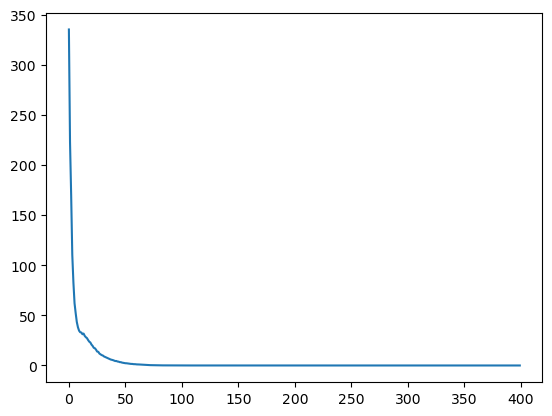

In [338]:
# Define the size of our "measurement" vector as encoding_dim. This needs to be larger than the sparsity of our matrix

# encoding_dim = max_sparsity
# encoding_dim = 100
# vector_size = 100
encoding_dim = vector_size
# Initialize model
feedthrough_model = FeedthroughEncoder(vector_size, encoding_dim)
optimizer = torch.optim.Adam(feedthrough_model.parameters(), lr=1E-2, weight_decay=1E-6)
loss_fn = nn.MSELoss()

# def complex_mse_loss(input, target):
#     return F.mse_loss(input, target)

# Training loop
losses = []
for epoch in range(20):
    for batch in dataloader:
        inputs, targets = batch  # Unpack the tuple
        optimizer.zero_grad()
        output = feedthrough_model(inputs)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

plt.plot(losses)
plt.show()

In [ ]:
print(output[-1] - targets[-1])
print(output[0,:])

## Train the AutoEncoder Model

In [ ]:
# Training variables: Beta_momentum, beta_variance, learning_rate, encoding_dim, sparsity, weight_decay

# Current Iteration: 1
# Beta_momentum: 0.95
# Beta_variance: 0.99
# Learning_rate: 1E-3
# weight_decay = 0
# sparsity = 3-5

encoding_dim = 50
print(vector_size)

# Initialize model
hidden_dims = np.array([60,80])
learned_autoencoder_model = LearnedAutoencoder(vector_size,encoding_dim,hidden_dims)
optimizer = torch.optim.Adam(learned_autoencoder_model.parameters(), lr=1E-3, betas=(0.9,0.999))
loss_fn = nn.MSELoss()

# def complex_mse_loss(input, target):
#     return F.mse_loss(input, target)

# Training loop
losses = []
for epoch in range(5000):
    for batch in dataloader:
        inputs, targets = batch  # Unpack the tuple
        optimizer.zero_grad()
        output = learned_autoencoder_model(inputs)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

plt.plot(losses)
plt.show()

100
Epoch 1, Loss: 66.024460
Epoch 2, Loss: 64.470711
Epoch 3, Loss: 63.016510
Epoch 4, Loss: 59.639290
Epoch 5, Loss: 58.616959
Epoch 6, Loss: 53.930084
Epoch 7, Loss: 49.401184
Epoch 8, Loss: 43.812191
Epoch 9, Loss: 42.182533
Epoch 10, Loss: 40.103924
Epoch 11, Loss: 35.878117
Epoch 12, Loss: 33.623386
Epoch 13, Loss: 31.292963
Epoch 14, Loss: 31.786097
Epoch 15, Loss: 29.178890
Epoch 16, Loss: 28.041660
Epoch 17, Loss: 27.668400
Epoch 18, Loss: 25.381590
Epoch 19, Loss: 24.900524
Epoch 20, Loss: 25.015696
Epoch 21, Loss: 23.083241
Epoch 22, Loss: 22.756624
Epoch 23, Loss: 22.544847
Epoch 24, Loss: 21.111860
Epoch 25, Loss: 21.077827
Epoch 26, Loss: 19.265312
Epoch 27, Loss: 20.760088
Epoch 28, Loss: 19.990765
Epoch 29, Loss: 19.513893
Epoch 30, Loss: 18.169304
Epoch 31, Loss: 19.138508
Epoch 32, Loss: 17.288574
Epoch 33, Loss: 16.897245
Epoch 34, Loss: 16.432138
Epoch 35, Loss: 16.749144
Epoch 36, Loss: 15.748247
Epoch 37, Loss: 15.711533
Epoch 38, Loss: 16.118183
Epoch 39, Loss: 1

KeyboardInterrupt: 

Some conclusions that we have found so far:
- Batch size must be minimally greater than 100. 500 seems to work well.
- 2 hidden layers of size 50,70 leads to a loss of 0.3 MSE
- Decreasing variance below 0.999 does not seem to have a positive effect


## Train noisy model

In [361]:
# Training variables: Beta_momentum, beta_variance, learning_rate, encoding_dim, sparsity, weight_decay

# Current Iteration: 1
# Beta_momentum: 0.9
# Beta_variance: 0.999
# Learning_rate: 1E-3
# weight_decay = 0
# sparsity = 3-5
# variance = 1

variance = 5
# Initialize model
hidden_dims = np.array([60,80])
noisy_autoencoder_model = LearnedAutoencoderWithNoise(vector_size,encoding_dim,hidden_dims,variance)
optimizer = torch.optim.Adam(noisy_autoencoder_model.parameters(), lr=1E-3, betas=(0.9,0.999))
loss_fn = nn.MSELoss()

# def complex_mse_loss(input, target):
#     return F.mse_loss(input, target)

# Training loop
losses = []
for epoch in range(5000):
    for batch in dataloader:
        inputs, targets = batch  # Unpack the tuple
        optimizer.zero_grad()
        output = noisy_autoencoder_model(inputs)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

plt.plot(losses)
plt.show()

Epoch 1, Loss: 66.096909
Epoch 2, Loss: 66.482292
Epoch 3, Loss: 57.894409
Epoch 4, Loss: 52.653721
Epoch 5, Loss: 45.716419
Epoch 6, Loss: 40.214931
Epoch 7, Loss: 36.596413
Epoch 8, Loss: 33.485035
Epoch 9, Loss: 31.532370
Epoch 10, Loss: 30.257006
Epoch 11, Loss: 27.782480
Epoch 12, Loss: 26.523094
Epoch 13, Loss: 26.014324
Epoch 14, Loss: 24.586103
Epoch 15, Loss: 24.031298
Epoch 16, Loss: 22.539579
Epoch 17, Loss: 22.516245
Epoch 18, Loss: 20.969582
Epoch 19, Loss: 20.164660
Epoch 20, Loss: 19.927385
Epoch 21, Loss: 19.919714
Epoch 22, Loss: 19.284800
Epoch 23, Loss: 18.783789
Epoch 24, Loss: 18.258902
Epoch 25, Loss: 17.888321
Epoch 26, Loss: 17.397209
Epoch 27, Loss: 17.557726
Epoch 28, Loss: 17.178776
Epoch 29, Loss: 15.676501
Epoch 30, Loss: 17.046177
Epoch 31, Loss: 16.663561
Epoch 32, Loss: 15.584452
Epoch 33, Loss: 15.799648
Epoch 34, Loss: 14.998041
Epoch 35, Loss: 14.475596
Epoch 36, Loss: 15.272154
Epoch 37, Loss: 15.339888
Epoch 38, Loss: 14.433413
Epoch 39, Loss: 14.28

KeyboardInterrupt: 

## Initialize pre-trained noiseless model

In [264]:
# Instantiate your model architecture first
encoding_dim = 50
vector_size = 100
hidden_dims = np.array([50,70])
pretrained_model = LearnedAutoencoder(vector_size,encoding_dim,hidden_dims)
# Load the state dictionary
pretrained_model.load_state_dict(torch.load("model_state_hidden_layers_50_70.pt"))

pretrained_model.eval()  # Set the model to evaluation mode if needed

C:\Users\tomli\AppData\Local\Temp\ipykernel_23912\380755522.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_model.load_state_dict(torch.load("model_state_hidd

LearnedAutoencoder(
  (encoder): ComplexLinearUnitary()
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=140, bias=True)
    (3): ReLU()
    (4): Linear(in_features=140, out_features=200, bias=True)
  )
)

## Show the output for a given sparse input vector



In [306]:
# Here we generate a test vector from our buildDataSet function, put it through the model and look at the output


h, x = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,1)

H = np.concatenate((h.real,h.imag)).T

H_tensor = torch.tensor(H,dtype=torch.float)

H_hat = pretrained_model(H_tensor)

h_hat = np.array(H_hat.detach())

h_real,h_imag = np.split(h_hat,2,1)
h_hat = h_real + 1j*h_imag
h_hat = h_hat.reshape(-1,1)
DFT = sp.linalg.dft(vector_size)/np.sqrt(vector_size)
iDFT = DFT.conj().T


x_hat = iDFT@h_hat
indices = range(len(x_hat))


c:\Users\tomli\anaconda3\envs\pytorch_311\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\tomli\anaconda3\envs\pytorch_311\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


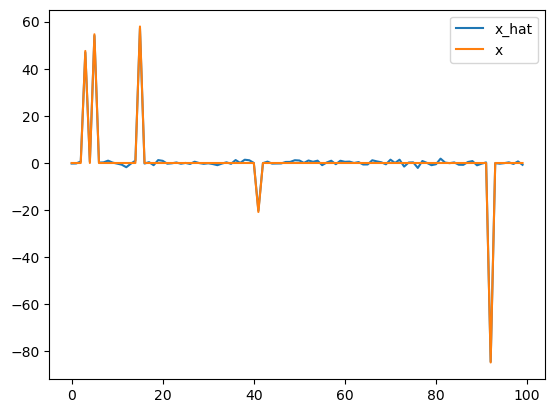

In [ ]:
plt.vlines(indices,0,x,linewidth=3)
plt.vlines(indices,0,x_hat,colors="orange")

plt.legend(("x","x_hat"))

## Extract the encoding matrix, generate a (noisy) y and use the decoder to find $\hat{h}$, then plot $\hat{x}$

In [359]:
# Load the autoencoder

encoding_dim = 50
vector_size = 100
hidden_dims = np.array([60,80])
variance = 5
noisy_autoencoder = LearnedAutoencoderWithNoise(vector_size,encoding_dim,hidden_dims,variance)
noisy_autoencoder.load_state_dict(torch.load("noisy_autoencoder_60_80.pt",))
noisy_autoencoder.eval()

# Build the W matrix
q_values = noisy_autoencoder_model.encoder.q_values

W_real = torch.cos(q_values)
W_imag = torch.sin(q_values)
W_top = torch.cat([W_real, -W_imag], dim=1)  # [W_real, -W_imag]
W_bottom = torch.cat([W_imag, W_real], dim=1)  # [W_imag, W_real]
W_total = torch.cat([W_top, W_bottom], dim=0)  # Stack rows to form the full matrix 

# Build the input vector

h, x = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,1)

H = np.concatenate((h.real,h.imag)).T

H_tensor = torch.tensor(H,dtype=torch.float)

y = torch.matmul(H_tensor,W_total.T)

# Make the noise

variance = 10

noise_np = np.random.normal(0,variance,size=100)
noise = torch.tensor(noise_np,dtype=torch.float)
noisy_y = y + noise

# Rebuild h, and x from the noisy y using the decoder

H_hat = noisy_autoencoder_model.decoder(noisy_y)

h_hat = np.array(H_hat.detach())

h_real,h_imag = np.split(h_hat,2,1)
h_hat = h_real + 1j*h_imag
h_hat = h_hat.reshape(-1,1)
DFT = sp.linalg.dft(vector_size)/np.sqrt(vector_size)
iDFT = DFT.conj().T


x_hat = iDFT@h_hat
indices = range(len(x_hat))

C:\Users\tomli\AppData\Local\Temp\ipykernel_23912\4033301142.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  noisy_autoencoder.load_state_dict(torch.load("noisy_autoenco

## Plotting

c:\Users\tomli\anaconda3\envs\pytorch_311\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\tomli\anaconda3\envs\pytorch_311\Lib\site-packages\numpy\ma\core.py:3413: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


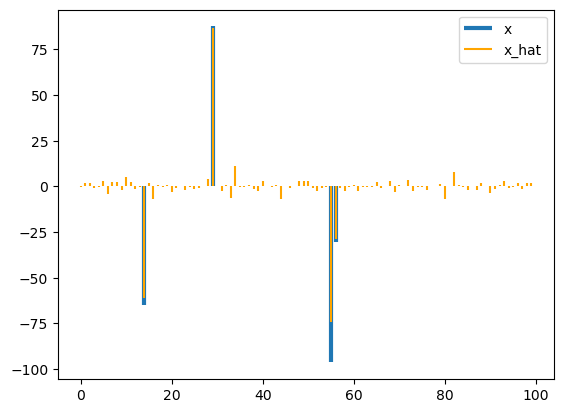

In [360]:
plt.vlines(indices,0,x,linewidth=3)
plt.vlines(indices,0,x_hat,colors="orange")

plt.legend(("x","x_hat"))

## Show the weights

In [332]:
# THIS DOESN'T WORK. TO BE FIXED

for idx, layer in enumerate(pretrained_model.decoder):
    # Check if the layer is an instance of ComplexLinear
    if isinstance(layer, nn.Linear):
        print(f"Decoder layer {idx} (ComplexLinear) W_real:")
        print(layer.weight)
        print(f"Decoder layer {idx} (ComplexLinear) W_imag:")
        print(layer.weight)

Decoder layer 0 (ComplexLinear) W_real:
Parameter containing:
tensor([[-0.0016, -0.0323,  0.1041,  ...,  0.0468, -0.0592,  0.0327],
        [-0.0235, -0.0134, -0.0171,  ...,  0.0216,  0.0314,  0.0259],
        [ 0.0065, -0.0328, -0.0397,  ..., -0.0214,  0.0142,  0.0223],
        ...,
        [ 0.0561, -0.1109,  0.1659,  ..., -0.0796, -0.3391,  0.1045],
        [-0.0328, -0.0145,  0.0484,  ..., -0.0230,  0.0081,  0.0506],
        [ 0.0097, -0.0984,  0.0116,  ...,  0.1054,  0.0210,  0.0204]],
       requires_grad=True)
Decoder layer 0 (ComplexLinear) W_imag:
Parameter containing:
tensor([[-0.0016, -0.0323,  0.1041,  ...,  0.0468, -0.0592,  0.0327],
        [-0.0235, -0.0134, -0.0171,  ...,  0.0216,  0.0314,  0.0259],
        [ 0.0065, -0.0328, -0.0397,  ..., -0.0214,  0.0142,  0.0223],
        ...,
        [ 0.0561, -0.1109,  0.1659,  ..., -0.0796, -0.3391,  0.1045],
        [-0.0328, -0.0145,  0.0484,  ..., -0.0230,  0.0081,  0.0506],
        [ 0.0097, -0.0984,  0.0116,  ...,  0.1054,  